In [1]:
import os

In [2]:
!gdown 1RxLFWqZRLbt3XYFjGve8zr-f0TYYE0iH

Downloading...
From: https://drive.google.com/uc?id=1RxLFWqZRLbt3XYFjGve8zr-f0TYYE0iH
To: /content/car-or-truck.zip
100% 81.5M/81.5M [00:01<00:00, 77.6MB/s]


In [3]:
!unzip car-or-truck.zip -d car-or-truck

Streaming output truncated to the last 5000 lines.
  inflating: car-or-truck/valid/Car/05205.jpeg  
  inflating: car-or-truck/valid/Car/05206.jpeg  
  inflating: car-or-truck/valid/Car/05208.jpeg  
  inflating: car-or-truck/valid/Car/05213.jpeg  
  inflating: car-or-truck/valid/Car/05214.jpeg  
  inflating: car-or-truck/valid/Car/05217.jpeg  
  inflating: car-or-truck/valid/Car/05218.jpeg  
  inflating: car-or-truck/valid/Car/05219.jpeg  
  inflating: car-or-truck/valid/Car/05221.jpeg  
  inflating: car-or-truck/valid/Car/05222.jpeg  
  inflating: car-or-truck/valid/Car/05225.jpeg  
  inflating: car-or-truck/valid/Car/05226.jpeg  
  inflating: car-or-truck/valid/Car/05227.jpeg  
  inflating: car-or-truck/valid/Car/05228.jpeg  
  inflating: car-or-truck/valid/Car/05234.jpeg  
  inflating: car-or-truck/valid/Car/05236.jpeg  
  inflating: car-or-truck/valid/Car/05238.jpeg  
  inflating: car-or-truck/valid/Car/05239.jpeg  
  inflating: car-or-truck/valid/Car/05241.jpeg  
  inflating: car-o

In [4]:
train_path = './car-or-truck/train/'
test_path = './car-or-truck/valid/'

In [5]:
print(len(os.listdir(train_path + 'Car/')))

2961


In [6]:
print(len(os.listdir(train_path + 'Truck/')))

2156


In [7]:
import cv2
from PIL import Image
import numpy as np

In [8]:
cates = ['Car', 'Truck']

def load_images_and_labels(data_path, cate):
  x = []
  y = []

  for index, cate in enumerate(cates):
    for img_name in os.listdir(data_path + cate + '/'):

      img = cv2.imread(data_path + cate + '/' + img_name)
      if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = Image.fromarray(img, 'RGB')
        img_rs = img_array.resize((224, 224))
        img_rs = np.array(img_rs)
        x.append(img_rs)
        y.append(index)
  return x, y

In [9]:
X_train, y_train = load_images_and_labels(train_path, cates)

In [10]:
X_test, y_test = load_images_and_labels(test_path, cates)

In [11]:
print(len(X_test))

5051


In [12]:
import matplotlib.pyplot as plt
import random

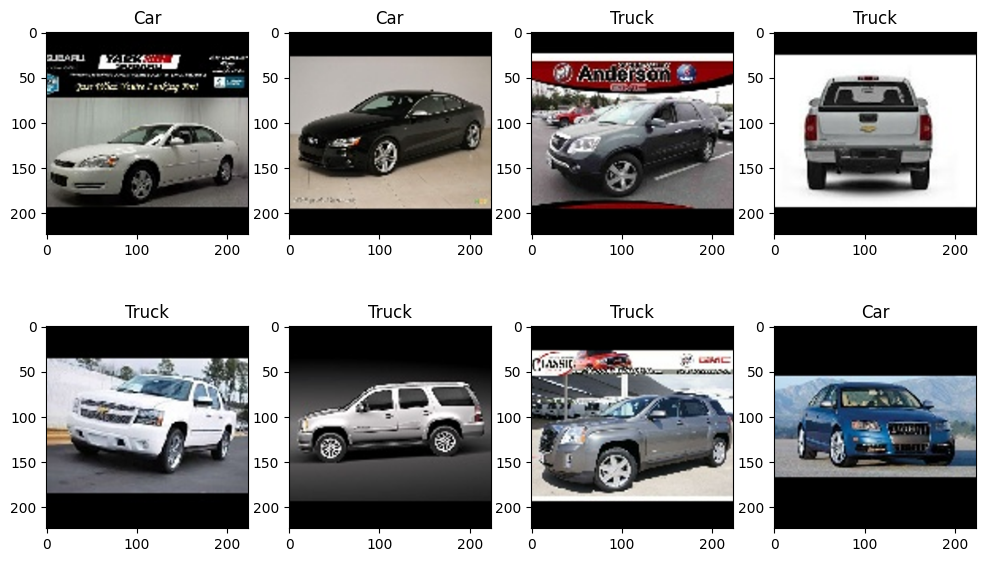

In [13]:
plt.figure(figsize=(12, 7))

for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240+1+i)
  plt.imshow(X_train[ind])
  plt.title(cates[y_train[ind]])

In [14]:
from keras.utils import to_categorical

In [15]:
def preprocess_data(X, y):

  X = np.array(X)

  X = X.astype(np.float32)

  X = X/255.0

  y = to_categorical(np.array(y))

  return X, y

In [16]:
(X_train, y_train) = preprocess_data(X_train, y_train)

In [17]:
X_train.shape

(5117, 224, 224, 3)

In [18]:
(X_test, y_test) = preprocess_data(X_test, y_test)

In [19]:
X_test.shape

(5051, 224, 224, 3)

In [20]:
from keras.applications.vgg16 import VGG16

In [21]:
vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))

58889256/58889256 [==============================] - 2s 0us/step


In [22]:
for layer in vgg.layers[:-5]:
  layer.trainable = False

In [23]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
from keras import layers
from keras.models import Model

In [25]:
last = vgg.output
x = layers.Flatten()(last)
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax')(x)
model = Model(vgg.input, output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
from keras.optimizers import Adam

In [27]:
model.compile(optimizer= Adam(learning_rate= 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [29]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):

  datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,)

  it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
  it_test = datagen.flow(X_test, y_test, batch_size=batch_size)


  path_cp = os.getcwd() + '/' + 'weights.hdf5'

  checkpoint = ModelCheckpoint(path_cp, monitor='loss', save_best_only=True, mode='auto')

  steps = X_train.shape[0]//batch_size

  history = model.fit(it_train, epochs= epochs, steps_per_epoch=steps, validation_data=it_test, verbose=1, callbacks=checkpoint)

  _, acc = model.evaluate(it_test, verbose=1)
  print('%.3f' % (acc*100.0))

  return history, acc

In [30]:
tain_history, acc = train_model(model, X_train, y_train, X_test, y_test, 5, 128)

Epoch 1/5
39/39 [==============================] - 169s 4s/step - loss: 0.5226 - accuracy: 0.7288 - val_loss: 0.2781 - val_accuracy: 0.8820
Epoch 2/5
39/39 [==============================] - 124s 3s/step - loss: 0.2626 - accuracy: 0.8874 - val_loss: 0.2063 - val_accuracy: 0.9141
Epoch 3/5
39/39 [==============================] - 124s 3s/step - loss: 0.1872 - accuracy: 0.9246 - val_loss: 0.1574 - val_accuracy: 0.9341
Epoch 4/5
39/39 [==============================] - 123s 3s/step - loss: 0.1350 - accuracy: 0.9451 - val_loss: 0.1757 - val_accuracy: 0.9313
Epoch 5/5
40/40 [==============================] - 59s 1s/step - loss: 0.1365 - accuracy: 0.9426
94.259


In [31]:
def plot_accuracy(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='red', label='val')

  plt.legend()
  plt.show()


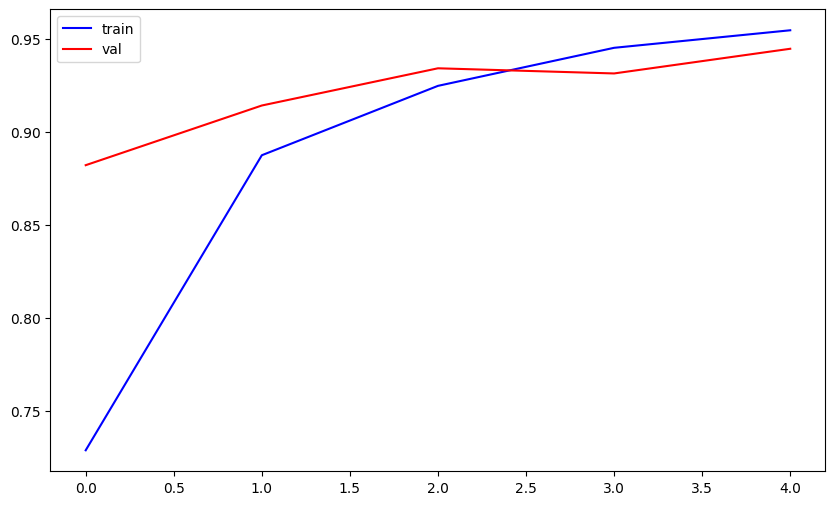

In [32]:
plot_accuracy(tain_history)

In [33]:
model.trainable = True

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
model.compile(optimizer= Adam(learning_rate= 1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

In [43]:
def train_model(model, X_train, y_train, X_test, y_test, Total_epochs, batch_size, train_history):

  datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,)

  it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
  it_test = datagen.flow(X_test, y_test, batch_size=batch_size)


  path_cp = os.getcwd() + '/' + 'weights.hdf5'

  checkpoint = ModelCheckpoint(path_cp, monitor='loss', save_best_only=True, mode='auto')

  steps = X_train.shape[0]//batch_size

  history = model.fit(it_train, epochs= Total_epochs, initial_epoch= train_history.epoch[-1], steps_per_epoch=steps, validation_data=it_test, verbose=1, callbacks=checkpoint)

  _, acc = model.evaluate(it_test, verbose=1)
  print('%.3f' % (acc*100.0))

  return history, acc

In [46]:
train_history, acc = train_model(model, X_train, y_train, X_test, y_test, 10, 128, tain_history)

Epoch 5/10
39/39 [==============================] - 181s 5s/step - loss: 0.0753 - accuracy: 0.9711 - val_loss: 0.1023 - val_accuracy: 0.9590
Epoch 6/10
39/39 [==============================] - 150s 4s/step - loss: 0.0509 - accuracy: 0.9828 - val_loss: 0.1035 - val_accuracy: 0.9576
Epoch 7/10
39/39 [==============================] - 149s 4s/step - loss: 0.0419 - accuracy: 0.9840 - val_loss: 0.0950 - val_accuracy: 0.9624
Epoch 8/10
39/39 [==============================] - 137s 4s/step - loss: 0.0420 - accuracy: 0.9838 - val_loss: 0.1008 - val_accuracy: 0.9614
Epoch 9/10
39/39 [==============================] - 141s 4s/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.0807 - val_accuracy: 0.9707
Epoch 10/10
40/40 [==============================] - 59s 1s/step - loss: 0.0892 - accuracy: 0.9663
96.634


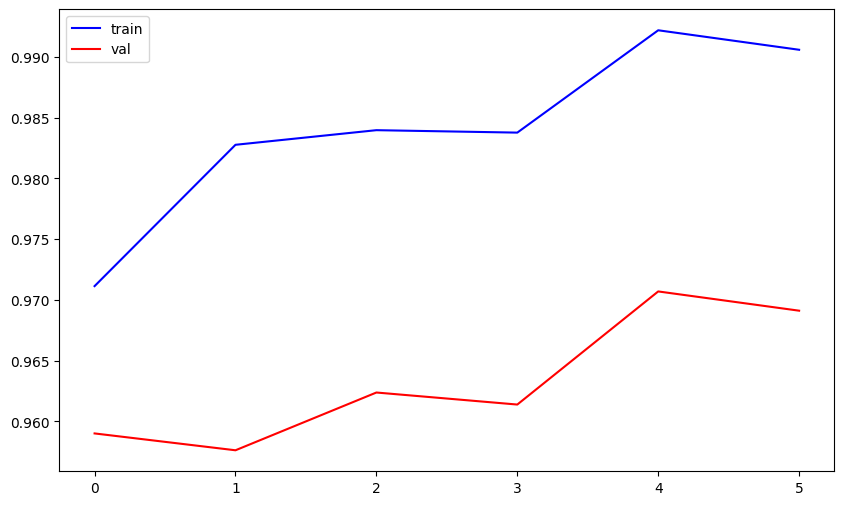

In [47]:
plot_accuracy(train_history)

## Save the trained model

In [48]:
model.save('model.h5')